**Learning-to-Rank with pairwise optimization**

Move from heuristic ranking (like Popularity or PPR) to optimized ranking models by implementing Bayesian Personalized Ranking (BPR-OPT)

In [10]:
# imports
import sys
sys.path.append("../src")
sys.path.append("../src/evaluation")
sys.path.append("../src/models")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit, prange
from collections import defaultdict
from utils.data_loader import MovieLensDataLoader
from evaluator import RecommenderEvaluator
from scipy.sparse import csr_matrix

loader = MovieLensDataLoader()
train, val, test = loader.load_splits()

n_users = train['user_id'].max() + 1
n_items = train['item_id'].max() + 1

Train: 797,758 | Val: 97,383 | Test: 105,068


In [2]:
THRESHOLD = 4.0
pos_df = train[train['rating'] >= THRESHOLD]
user_pos_items = pos_df.groupby('user_id')['item_id'].apply(set).to_dict()
user_all_items = train.groupby('user_id')['item_id'].apply(set).to_dict()

In [3]:
# BPR epoch with uniform negative sampling
@njit(fastmath=True)
def bpr_epoch(user_ids, pos_items_flat, pos_offsets, pos_counts,
              n_items, user_factors, item_factors, user_bias, item_bias,
              lr, reg, n_samples):
    loss = 0.0
    n_users = len(pos_offsets)
    
    for _ in range(n_samples):
        # sample a random user who has at least one positive interaction
        u = np.random.randint(0, n_users)
        uid = user_ids[u]
        count = pos_counts[u]
        if count == 0:
            continue
        offset = pos_offsets[u]
        
        # sample a positive item from this user's history
        pi = pos_items_flat[offset + np.random.randint(0, count)]
        
        # sample a negative item uniformly
        ni = np.random.randint(0, n_items)
        attempts = 0
        while attempts < 10:
            found = False
            for k in range(count):
                if pos_items_flat[offset + k] == ni:
                    found = True
                    break
            if not found:
                break
            ni = np.random.randint(0, n_items)
            attempts += 1
        # calculate pairwise difference: x_uij = score(u,i) - score(u,j)
        x_ui = user_bias[uid] + item_bias[pi] + np.dot(user_factors[uid], item_factors[pi])
        x_uj = user_bias[uid] + item_bias[ni] + np.dot(user_factors[uid], item_factors[ni])
        x_uij = x_ui - x_uj
        
        # sigmoid and log loss
        sig = 1.0 / (1.0 + np.exp(x_uij))
        loss += np.log(1.0 / (1.0 + np.exp(-x_uij)) + 1e-10)
        
        # apply sgd update
        user_factors[uid] += lr * (sig * (item_factors[pi] - item_factors[ni]) - reg * user_factors[uid])
        item_factors[pi] += lr * (sig * user_factors[uid] - reg * item_factors[pi])
        item_factors[ni] += lr * (-sig * user_factors[uid] - reg * item_factors[ni])
        
        item_bias[pi] += lr * (sig - reg * item_bias[pi])
        item_bias[ni] += lr * (-sig - reg * item_bias[ni])
    
    return loss / n_samples

In [4]:
class BPRMF:
    def __init__(self, n_users, n_items, n_factors=64, lr=0.01, reg=0.001, n_epochs=30, samples_per_epoch=None):
        # hyperparameters
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.samples_per_epoch = samples_per_epoch
        
        np.random.seed(42)

        # latent factor matrices
        self.user_factors = np.random.normal(0, 0.01, (n_users, n_factors))
        self.item_factors = np.random.normal(0, 0.01, (n_items, n_factors))

        # zero biases
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.loss_history = []
    
    def fit(self, user_pos_items):
        # flatten user_pos_items into 1D array for numba
        user_ids = []
        pos_flat = []
        offsets = []
        counts = []
        offset = 0
        
        for uid in range(self.n_users):
            items = list(user_pos_items.get(uid, []))
            user_ids.append(uid)
            offsets.append(offset)
            counts.append(len(items))
            pos_flat.extend(items)
            offset += len(items)
        
        # convert type for numba
        user_ids = np.array(user_ids, dtype=np.int64)
        pos_flat = np.array(pos_flat, dtype=np.int64)
        offsets = np.array(offsets, dtype=np.int64)
        counts = np.array(counts, dtype=np.int64)
        
        n_samples = self.samples_per_epoch or len(pos_flat) * 5
        
        # main training loop
        for epoch in range(self.n_epochs):
            loss = bpr_epoch(user_ids, pos_flat, offsets, counts,
                           self.n_items, self.user_factors, self.item_factors,
                           self.user_bias, self.item_bias,
                           self.lr, self.reg, n_samples)
            self.loss_history.append(loss)
            if epoch % 5 == 0:
                print(f"epoch {epoch:3d}: loss = {loss:.4f}")
        
        print(f"epoch {self.n_epochs-1:3d}: loss = {self.loss_history[-1]:.4f}")
    
    def predict_for_user(self, user_id, k=10, train_df=None):
        if user_id >= self.n_users:
            return []
        # raw scores for all items
        scores = self.item_bias + self.item_factors @ self.user_factors[user_id]
        
        if train_df is not None:
            seen = train_df[train_df['user_id'] == user_id]['item_id'].values
            scores[seen] = -np.inf
        
        top_k = np.argpartition(scores, -k)[-k:]
        top_k = top_k[np.argsort(scores[top_k])[::-1]]
        return [(int(i), float(scores[i])) for i in top_k if scores[i] > -np.inf]

In [5]:
bpr = BPRMF(n_users, n_items, n_factors=64, lr=0.01, reg=0.001, n_epochs=40)
bpr.fit(user_pos_items)

epoch   0: loss = -0.3195
epoch   5: loss = -0.2369
epoch  10: loss = -0.1376
epoch  15: loss = -0.0891
epoch  20: loss = -0.0696
epoch  25: loss = -0.0586
epoch  30: loss = -0.0516
epoch  35: loss = -0.0467
epoch  39: loss = -0.0436


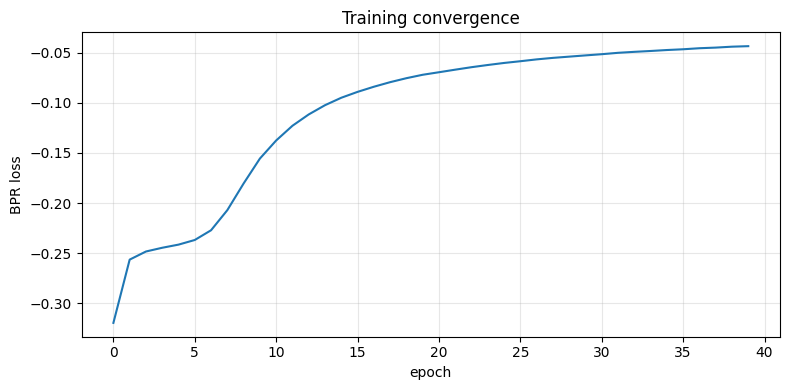

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(bpr.loss_history)
plt.xlabel("epoch")
plt.ylabel("BPR loss")
plt.title("Training convergence")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../experiments/figures/convergence.png", dpi=150)
plt.show()

loss is decreasing smoothly and model is converging, learning how to push scores of positive items higher than scores of negative samples

In [7]:
evaluator = RecommenderEvaluator(train, test, k_values=[5, 10, 20])
metrics_bpr = evaluator.evaluate_model(bpr, model_name="BPR-MF")
evaluator.print_metrics(metrics_bpr, model_name="BPR-MF")

BPR-MF - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0567
NDCG@10: 0.0664
NDCG@20: 0.0829


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0389
Precision@ 5: 0.0513
Recall@10: 0.0704
Precision@10: 0.0466
Recall@20: 0.1207
Precision@20: 0.0405


Diversity metrics:
Coverage: 0.4588
Popularity bias: 1095.25


In [11]:
# Heuristic Baselines for Comparison
class PopularityRanker:

    def __init__(self, train_df, min_ratings=5):
        counts = train_df.groupby('item_id').size()
        self.scores = counts.to_dict()
        self.ranked = counts[counts >= min_ratings].sort_values(ascending=False).index.tolist()

    def predict_for_user(self, user_id, k=10, train_df=None):
        seen = set(train_df[train_df['user_id'] == user_id]['item_id']) if train_df is not None else set()
        return [(iid, self.scores[iid]) for iid in self.ranked if iid not in seen][:k]

class PersonalizedPageRankRanker:
    def __init__(self, train_df, alpha=0.15, n_iterations=20, threshold=4.0):
        self.alpha = alpha
        self.n_iter = n_iterations
        df = train_df[train_df['rating'] >= threshold]
        self.n_users = train_df['user_id'].max() + 1
        self.n_items = train_df['item_id'].max() + 1
        n = self.n_users + self.n_items
        rows = np.concatenate([df['user_id'].values, self.n_users + df['item_id'].values])
        cols = np.concatenate([self.n_users + df['item_id'].values, df['user_id'].values])
        data = np.ones(len(rows), dtype=np.float32)
        adj = csr_matrix((data, (rows, cols)), shape=(n, n))
        degree = np.array(adj.sum(axis=1)).flatten()
        degree[degree == 0] = 1
        inv_deg = 1.0 / degree
        self.transition = csr_matrix((inv_deg[adj.nonzero()[0]] * adj.data, adj.indices, adj.indptr), shape=(n, n))
        self.user_seen = {}
        for uid, g in train_df.groupby('user_id'):
            self.user_seen[uid] = set(g['item_id'])
        
    def run_ppr(self, user_id):
        n = self.n_users + self.n_items
        teleport = np.zeros(n, dtype=np.float32)
        teleport[user_id] = 1.0
        scores = teleport.copy()
        for _ in range(self.n_iter):
            scores = (1 - self.alpha) * (self.transition.T @ scores) + self.alpha * teleport
        return scores[self.n_users:]
        
    def predict_for_user(self, user_id, k=10, train_df=None):
        if user_id >= self.n_users:
            return []
        item_scores = self.run_ppr(user_id)
        seen = self.user_seen.get(user_id, set())
        for iid in seen:
            if iid < len(item_scores):
                item_scores[iid] = -np.inf
        top_k = np.argpartition(item_scores, -k)[-k:]
        top_k = top_k[np.argsort(item_scores[top_k])[::-1]]
        return [(int(i), float(item_scores[i])) for i in top_k if item_scores[i] > -np.inf]

In [12]:
pop = PopularityRanker(train)
ppr = PersonalizedPageRankRanker(train)

metrics_pop = evaluator.evaluate_model(pop, model_name="Popularity")
metrics_ppr = evaluator.evaluate_model(ppr, model_name="PPR")

In [13]:
results_df = pd.DataFrame(evaluator.history)
cols = ['Model', 'NDCG@5', 'NDCG@10', 'NDCG@20', 'Recall@10', 'Precision@10', 'Coverage', 'Popularity_Bias']
print(results_df[[c for c in cols if c in results_df.columns]].round(4).to_string(index=False))

     Model  NDCG@5  NDCG@10  NDCG@20  Recall@10  Precision@10  Coverage  Popularity_Bias
    BPR-MF  0.0567   0.0664   0.0829     0.0704        0.0466    0.4588        1095.2456
Popularity  0.0437   0.0490   0.0615     0.0433        0.0393    0.0513        2085.9076
       PPR  0.0475   0.0544   0.0667     0.0497        0.0428    0.0578        2052.9775


* BPR is winner across all accuracy metrics. explicit optimization of pairwise ranking pushes relevant items higher up compared to non-learned heuristics

* the most significant advantage is coverage (45.8%), meaning that it is able to reccomend broad catalog, rather than top list, resulting in halving popularity bias

In [14]:
# split items by popularity into quantiles
item_pop = train.groupby('item_id').size()
quantiles = item_pop.quantile([0.5, 0.9])
q50, q90 = quantiles.iloc[0], quantiles.iloc[1]

head_items = set(item_pop[item_pop >= q90].index)
mid_items = set(item_pop[(item_pop >= q50) & (item_pop < q90)].index)
tail_items = set(item_pop[item_pop < q50].index)

print(f"top 10%: {len(head_items)} items, Mid: {len(mid_items)}, bottom 50%: {len(tail_items)}")

top 10%: 367 items, Mid: 1468, bottom 50%: 1831


In [16]:
# NDCG@k computed only over ground-truth items in a given segment
def per_segment_ndcg(model, test_df, train_df, item_set, k=10):
    gt = defaultdict(dict)
    for _, row in test_df.iterrows():
        if row['item_id'] in item_set:
            gt[row['user_id']][row['item_id']] = row['rating']
    
    ndcgs = []
    for uid, truth in gt.items():
        preds = model.predict_for_user(uid, k=k, train_df=train_df)
        seg_preds = [(iid, s) for iid, s in preds if iid in item_set]
        if not truth:
            continue
        rel = [truth.get(iid, 0) for iid, _ in seg_preds[:k]]
        ideal = sorted(truth.values(), reverse=True)
        
        def dcg(scores, k):
            s = np.array(scores)[:k]
            if len(s) == 0: return 0.0
            return np.sum((2**s - 1) / np.log2(np.arange(2, len(s)+2)))
        
        d, id_ = dcg(rel, k), dcg(ideal, k)
        ndcgs.append(d / id_ if id_ > 0 else 0.0)
    
    return np.mean(ndcgs) if ndcgs else 0.0


In [17]:
# checking how well models performs on different types of movies (popular, mid, niche)

segments = {"Head": head_items, "Mid": mid_items, "Tail": tail_items}
models = {"BPR-MF": bpr, "Popularity": pop, "PPR": ppr}

seg_results = []
for mname, model in models.items():
    row = {"Model": mname}
    for sname, sset in segments.items():
        row[f"NDCG@10_{sname}"] = per_segment_ndcg(model, test, train, sset, k=10)
    seg_results.append(row)

seg_df = pd.DataFrame(seg_results)
print("Head vs Mid vs Tail NDCG@10:")
print(seg_df.round(4).to_string(index=False))

Head vs Mid vs Tail NDCG@10:
     Model  NDCG@10_Head  NDCG@10_Mid  NDCG@10_Tail
    BPR-MF        0.0884       0.0238        0.0012
Popularity        0.0662       0.0000        0.0000
       PPR        0.0737       0.0000        0.0000


* all models perform best on head items with BPR winning (0.088). maybe since it is easy to guess user will like top-10% blockbuster
* Both the Popularity and PPR rankers score exactly 0.0000 for the Mid and Tail segments, since they are driven by global interaction counts, mainly focused in head items
* BPR scores 0.0238 on Mid and 0.0012 on Tail. Though tiny, but non-zero and are capable of leaning, rather then memorizing top items

In [18]:
# negative sampling sensitivity
# BPR works by taking a positive item a user interacted with, randomly sampling a negative item they didn't interact with and updating their embeddings to push the positive item's score higher than the negative's
# we use multiplier to choose how many of these positive-negative pairs are sampled per epoch
sampling_results = []
for multiplier in [1, 5, 10, 20]:
    n_samp = len(pos_df) * multiplier
    model = BPRMF(n_users, n_items, n_factors=64, lr=0.01, reg=0.001, n_epochs=30, samples_per_epoch=n_samp)
    model.fit(user_pos_items)
    
    eval_tmp = RecommenderEvaluator(train, test, k_values=[10])
    m = eval_tmp.evaluate_model(model, model_name=f"BPR_x{multiplier}")
    sampling_results.append({"Multiplier": multiplier, "Samples": n_samp,
                            "NDCG@10": m['NDCG@10'], "Recall@10": m['Recall@10'],
                            "Coverage": m['Coverage']})

samp_df = pd.DataFrame(sampling_results)

print(samp_df.round(4).to_string(index=False))

epoch   0: loss = -0.4375
epoch   5: loss = -0.2634
epoch  10: loss = -0.2505
epoch  15: loss = -0.2462
epoch  20: loss = -0.2426
epoch  25: loss = -0.2385
epoch  29: loss = -0.2347
epoch   0: loss = -0.3199
epoch   5: loss = -0.2368
epoch  10: loss = -0.1375
epoch  15: loss = -0.0892
epoch  20: loss = -0.0694
epoch  25: loss = -0.0583
epoch  29: loss = -0.0526
epoch   0: loss = -0.2881
epoch   5: loss = -0.1302
epoch  10: loss = -0.0680
epoch  15: loss = -0.0509
epoch  20: loss = -0.0427
epoch  25: loss = -0.0379
epoch  29: loss = -0.0354
epoch   0: loss = -0.2674
epoch   5: loss = -0.0656
epoch  10: loss = -0.0420
epoch  15: loss = -0.0347
epoch  20: loss = -0.0312
epoch  25: loss = -0.0294
epoch  29: loss = -0.0284
 Multiplier  Samples  NDCG@10  Recall@10  Coverage
          1   469223   0.0502     0.0449    0.0286
          5  2346115   0.0661     0.0700    0.3423
         10  4692230   0.0651     0.0698    0.4242
         20  9384460   0.0646     0.0697    0.4686


* Multiplier 1 - NDCG@10 = 0.0502, Coverage = 2.8% - model performs poorly, because it only samples 1 negative item for every positive item per epoch, it simply did not see enough of the catalog to learn what the user dislikes. loss barely converges. it defaults to recommending only a fraction of catalog
* multiplier 5 - NDCG@10 = 0.0661, Coverage = 34.2% - optimal balance for accuracy. exposing 5 times as many negative examples provides enough contrast for separation, resulting in better accuracy and coverage
* multiplier 10 and 20 - coverate rises to 46.8%, but NDCG drops slightly to 0.0646 - though better and deeper exploration, but too many samples distract model slightly

In [19]:
evaluator.save_results("../experiments/results/bpr_comparison.csv")
seg_df.to_csv("../experiments/results/head_tail_analysis.csv", index=False)
samp_df.to_csv("../experiments/results/sampling_sensitivity.csv", index=False)